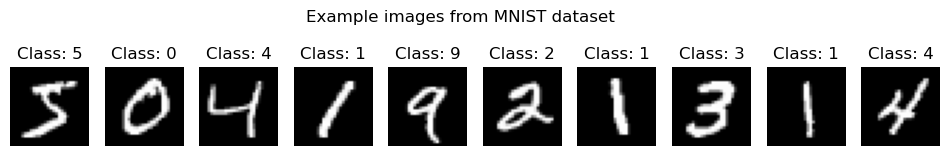

In [10]:
import torch
import numpy as np
from torchvision.transforms import v2, ToPILImage
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms.v2.functional as F

transform = v2.Compose([v2.PILToTensor()])
# Load MNIST dataset
X_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
X_test = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Visualize some samples
plt.figure(figsize=(12, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    input, classes = X_train[i]
    plt.imshow(input.squeeze(), cmap="gray")
    plt.title(f"Class: {classes}")
    plt.axis("off")

plt.suptitle("Example images from MNIST dataset")
plt.show()

## Very basic autoencoder

In [15]:
class Autoencoder(nn.Module):
    def __init__(self, patch_size, device="cpu"):
        super(Autoencoder, self).__init__()
        self.device = device
        self.patch_size = patch_size
        self.patch_dim = patch_size * patch_size * 1  # Grayscale image, so 1 channel

        # Encoding layer
        self.enc_fc = nn.Linear(self.patch_dim, 32)
        self.enc_act = nn.ReLU()

        # Decoding layer
        self.dec_fc = nn.Linear(32, self.patch_dim)
        self.dec_act = nn.Sigmoid()

    def encode(self, x):
        x = self.enc_fc(x)
        x = self.enc_act(x)
        return x

    def decode(self, x):
        x = self.dec_fc(x)
        x = self.dec_act(x)
        return x

    def forward(self, x):
        # Encoding and decoding patches
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded


In [83]:

patch_size = 4
mask_ratio = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def extract_patches(img, patch_size):
    imgp = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size).permute((0, 3, 4, 1, 2)).flatten(3).permute((3, 0, 1, 2))
    return imgp

def apply_mask(imgs, mask_ratio):
    batch_size, num_patches, patch_h, patch_w = imgs.shape
    mask_count = int(num_patches * mask_ratio)
    masks = torch.zeros(batch_size, num_patches).long()

    for i in range(batch_size):
        mask_idx = torch.randperm(num_patches)[:mask_count]
        masks[i, mask_idx] = 1  # Set the selected indices to 1 (mask)
    
    return masks

# Returns a tensor of size [batch_size, num_patches, patch_size, patch_size]
def collate_fn(batch):
    images, _ = zip(*batch)
    imgs = np.array([np.asarray(image) for image in images]) / 255.0
    imgs = torch.tensor(imgs, dtype=torch.float32)
    imgs = torch.cat([extract_patches(img, patch_size) for img in imgs], dim=1)
    imgs = imgs.permute(1, 0, 2, 3)
    return imgs

batch_size = 4
train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)


## Visualize

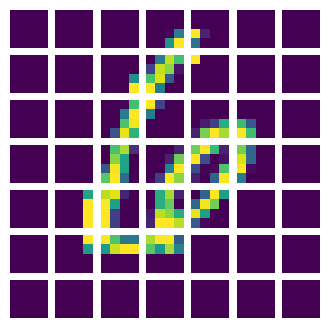

In [84]:
imgs = next(iter(train_loader))

img = imgs[0]
fig, ax = plt.subplots(figsize=(4, 4), nrows=7, ncols=7)
for n, i in enumerate(img):
    ax.flat[n].imshow(ToPILImage()(i))
    ax.flat[n].axis("off")
plt.show()

IndexError: tensors used as indices must be long, int, byte or bool tensors

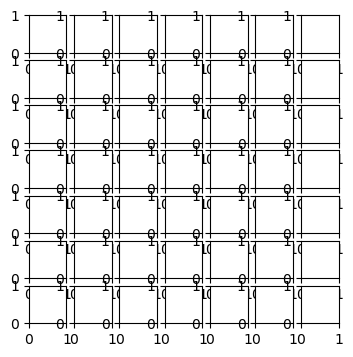

In [80]:
masks = apply_mask(imgs, mask_ratio)

img = imgs[0]
mask = mask
fig, ax = plt.subplots(figsize=(4, 4), nrows=7, ncols=7)
for n, i in enumerate(img):
    print(mask[])
    if mask[0][i]:
        ax.flat[n].imshow(ToPILImage()(i))
    ax.flat[n].axis("off")
plt.show()

In [ ]:

x, _ = X_train[0]
for i in range(2):
    input, label = X_train[i]
    x = torch.cat((x,input))
x.shape


torch.Size([3, 28, 28])

In [ ]:
patch_size = 4
for img in x:
    img

print(x.shape)
fold1 = x.unfold(1, patch_size, patch_size)
fold2 = fold1.unfold(2, patch_size, patch_size)
print(fold1.shape)
print(fold2.shape)
print(fold2.permute((0, 3, 4, 1, 2)).shape)
print(fold2.permute((0, 3, 4, 1, 2)).flatten(3).permute((3, 0, 1, 2)).shape)

torch.Size([3, 28, 28])
torch.Size([3, 7, 28, 4])
torch.Size([3, 7, 7, 4, 4])
torch.Size([3, 4, 4, 7, 7])
torch.Size([49, 3, 4, 4])


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/joona/anaconda3/envs/plankton/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/joona/anaconda3/envs/plankton/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_44082/2851056714.py", line 21, in collate_fn
    imgs = torch.stack([extract_patches(img.squeeze(), patch_size) for img in images])
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_44082/2851056714.py", line 6, in extract_patches
    imgp = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size).permute((0, 3, 4, 1, 2)).flatten(3).permute((3, 0, 1, 2))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 5
